In [17]:
# --- Sección 1: versiones y librerías base ---
import sys, sklearn, numpy as np, pandas as pd
import warnings
from packaging import version

print("Python:", sys.version)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("scikit-learn:", sklearn.__version__)

# No silenciamos todos los warnings: sólo algunos ruidosos
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
pandas: 2.2.2
numpy: 2.0.2
scikit-learn: 1.6.1


In [29]:
# --- Sección 2: carga de datos y configuración ---
import pandas as pd
from IPython.display import display

# ⚠️ EDITA AQUÍ: ruta/nombre de tu CSV
CSV_PATH = "productos.csv"

# ⚠️ EDITA AQUÍ: nombre de la columna objetivo
TARGET = "categoria_objetivo"

df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
display(df.head(3))

# Chequeo rápido de nulos
display(df.isna().sum().to_frame("nulos").T)

# Separamos X, y
assert TARGET in df.columns, f"La columna objetivo '{TARGET}' no existe en el dataset."
X = df.drop(columns=[TARGET])
y = df[TARGET].copy()

# Detección automática de tipos
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)

# Si tienes columnas de fecha en texto y quieres derivar 'días a evento', hazlo aquí:
# Ejemplo:
# if "fecha_vencimiento" in X.columns:
#     X["fecha_vencimiento"] = pd.to_datetime(X["fecha_vencimiento"], errors="coerce")
#     X["dias_a_vencer"] = (X["fecha_vencimiento"] - pd.Timestamp.today().normalize()).dt.days
#     num_cols = [c for c in num_cols if c != "fecha_vencimiento"]
#     num_cols += ["dias_a_vencer"]
#     X = X.drop(columns=["fecha_vencimiento"])

Shape: (200, 6)


,id_producto,peso,volumen,tipo_certificacion,fecha_vencimiento,categoria_objetivo
0,P001,599.34,1143.11,temperatura,216,2
1,P002,472.35,1224.31,temperatura,154,2
2,P003,629.54,1433.22,temperatura,14,1


,id_producto,peso,volumen,tipo_certificacion,fecha_vencimiento,categoria_objetivo
nulos,0,0,0,0,0,0


Numéricas: ['peso', 'volumen', 'fecha_vencimiento']
Categóricas: ['id_producto', 'tipo_certificacion']


In [19]:
# --- Sección 3: train/test split ---
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape)


(160, 5) (40, 5)


In [20]:
# --- Sección 4: preprocesamiento ---
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Compatibilidad con distintas versiones de scikit-learn para OneHotEncoder
ohe_kwargs = {"handle_unknown": "ignore"}
if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe_kwargs["sparse_output"] = False
else:
    ohe_kwargs["sparse"] = False

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop=None, **ohe_kwargs), cat_cols)
    ],
    remainder="drop"
)


In [21]:
# --- Sección 5: modelos y grids ---
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

dt_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(random_state=42))
])

mlp_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", MLPClassifier(max_iter=1000, random_state=42))
])

dt_params = {
    "classifier__criterion": ["gini", "entropy"],
    "classifier__max_depth": [None, 3, 5, 10, 20],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 5, 10],
    "classifier__class_weight": [None, "balanced"],
    "classifier__ccp_alpha": [0.0, 1e-3, 1e-2]
}

mlp_params = {
    "classifier__hidden_layer_sizes": [(50,), (100,), (100,50), (50,50)],
    "classifier__activation": ["relu", "tanh"],
    "classifier__alpha": [1e-5, 1e-4, 1e-3],
    "classifier__learning_rate_init": [1e-2, 1e-3],
    "classifier__batch_size": [32, 64],
    "classifier__early_stopping": [True],
    "classifier__n_iter_no_change": [10]
}


In [22]:
# --- Sección 6: GridSearchCV ---
from sklearn.model_selection import StratifiedKFold, GridSearchCV

cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"f1_macro": "f1_macro", "bal_acc": "balanced_accuracy"}

grid_dt = GridSearchCV(
    estimator=dt_pipe,
    param_grid=dt_params,
    scoring=scoring,
    refit="f1_macro",
    cv=cv5,
    n_jobs=-1,
    verbose=1
)
grid_dt.fit(X_train, y_train)

grid_mlp = GridSearchCV(
    estimator=mlp_pipe,
    param_grid=mlp_params,
    scoring=scoring,
    refit="f1_macro",
    cv=cv5,
    n_jobs=-1,
    verbose=1
)
grid_mlp.fit(X_train, y_train)

print("Mejor DT:", grid_dt.best_params_, "->", grid_dt.best_score_)
print("Mejor MLP:", grid_mlp.best_params_, "->", grid_mlp.best_score_)


Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Mejor DT: {'classifier__ccp_alpha': 0.0, 'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2} -> 1.0
Mejor MLP: {'classifier__activation': 'relu', 'classifier__alpha': 0.0001, 'classifier__batch_size': 32, 'classifier__early_stopping': True, 'classifier__hidden_layer_sizes': (50, 50), 'classifier__learning_rate_init': 0.01, 'classifier__n_iter_no_change': 10} -> 0.9619133885438232



== Árbol de Decisión ==
              precision    recall  f1-score   support

           1      1.000     1.000     1.000         6
           2      1.000     1.000     1.000        15
           3      1.000     1.000     1.000         5
           4      1.000     1.000     1.000        14

    accuracy                          1.000        40
   macro avg      1.000     1.000     1.000        40
weighted avg      1.000     1.000     1.000        40



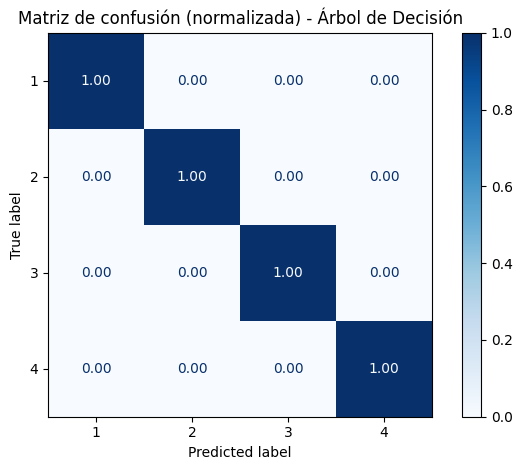


== MLP ==
              precision    recall  f1-score   support

           1      1.000     1.000     1.000         6
           2      1.000     1.000     1.000        15
           3      1.000     1.000     1.000         5
           4      1.000     1.000     1.000        14

    accuracy                          1.000        40
   macro avg      1.000     1.000     1.000        40
weighted avg      1.000     1.000     1.000        40



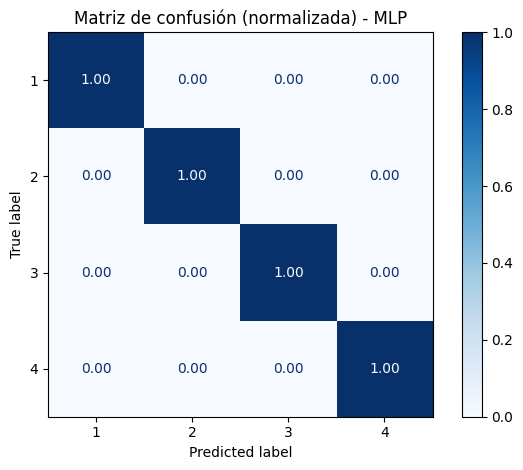

In [23]:
# --- Sección 7: evaluación en test ---
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

best_dt = grid_dt.best_estimator_
best_mlp = grid_mlp.best_estimator_

modelos = {
    "Árbol de Decisión": best_dt,
    "MLP": best_mlp
}

for nombre, modelo in modelos.items():
    y_pred = modelo.predict(X_test)
    print(f"\n== {nombre} ==")
    print(classification_report(y_test, y_pred, digits=3))
    disp = ConfusionMatrixDisplay.from_estimator(
        modelo, X_test, y_test,
        normalize="true", values_format=".2f", cmap="Blues"
    )
    plt.title(f"Matriz de confusión (normalizada) - {nombre}")
    plt.tight_layout()
    plt.show()


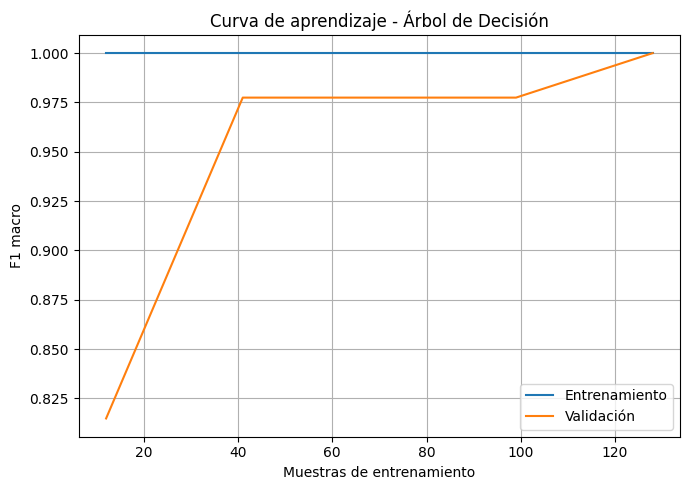

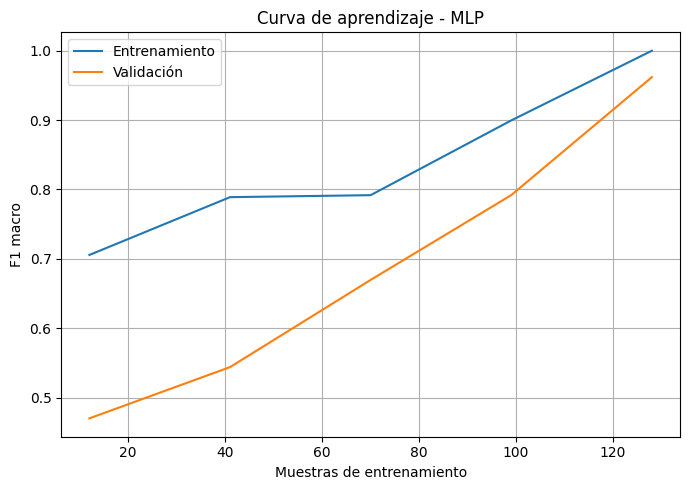

In [24]:
# --- Sección 8: curvas de aprendizaje ---
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

for nombre, modelo in modelos.items():
    train_sizes, train_scores, val_scores = learning_curve(
        modelo, X_train, y_train,
        cv=cv5, scoring="f1_macro", n_jobs=-1
    )
    plt.figure(figsize=(7,5))
    plt.plot(train_sizes, train_scores.mean(axis=1), label="Entrenamiento")
    plt.plot(train_sizes, val_scores.mean(axis=1), label="Validación")
    plt.title(f"Curva de aprendizaje - {nombre}")
    plt.xlabel("Muestras de entrenamiento")
    plt.ylabel("F1 macro")
    plt.grid(True); plt.legend(); plt.tight_layout()
    plt.show()


In [25]:
# --- Sección 9: AUC/ROC OVR ---
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

clases = np.sort(pd.unique(y_train))  # clases presentes
is_multiclass = len(clases) > 2

def multiclass_auc_ovr(model, X, y, classes):
    y_bin = label_binarize(y, classes=classes)
    if y_bin.shape[1] == 1:
        # Caso binario: scikit-learn hace 1 columna; tratamos como binario
        proba = model.predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(y, proba, pos_label=classes[1])
        return float(auc(fpr, tpr))
    else:
        proba = model.predict_proba(X)
        aucs = []
        for i in range(len(classes)):
            fpr, tpr, _ = roc_curve(y_bin[:, i], proba[:, i])
            aucs.append(auc(fpr, tpr))
        return float(np.mean(aucs))

for nombre, modelo in modelos.items():
    if hasattr(modelo, "predict_proba"):
        auc_val = multiclass_auc_ovr(modelo, X_test, y_test, clases)
        print(f"{nombre} -> AUC OVR promedio: {auc_val:.4f}")
    else:
        print(f"{nombre} -> no entrega predict_proba()")


Árbol de Decisión -> AUC OVR promedio: 1.0000
MLP -> AUC OVR promedio: 1.0000


In [26]:
# --- Sección 10: tiempos de entrenamiento e inferencia ---
import time

def tiempos(model, Xtr, ytr, Xte, reps=5):
    t0 = time.time()
    model.fit(Xtr, ytr)
    t_fit = time.time() - t0

    t0 = time.time()
    for _ in range(reps):
        _ = model.predict(Xte)
    t_pred = (time.time() - t0) / reps / len(Xte)
    return t_fit, t_pred

for nombre, modelo in modelos.items():
    # Clonamos el mejor estimador para no sobreescribirlo
    import copy
    m = copy.deepcopy(modelo)
    t_fit, t_pred = tiempos(m, X_train, y_train, X_test, reps=10)
    print(f"{nombre}: Entrenamiento={t_fit:.4f}s | Predicción por muestra={t_pred:.6f}s")


Árbol de Decisión: Entrenamiento=0.0139s | Predicción por muestra=0.000120s
MLP: Entrenamiento=0.0836s | Predicción por muestra=0.000131s


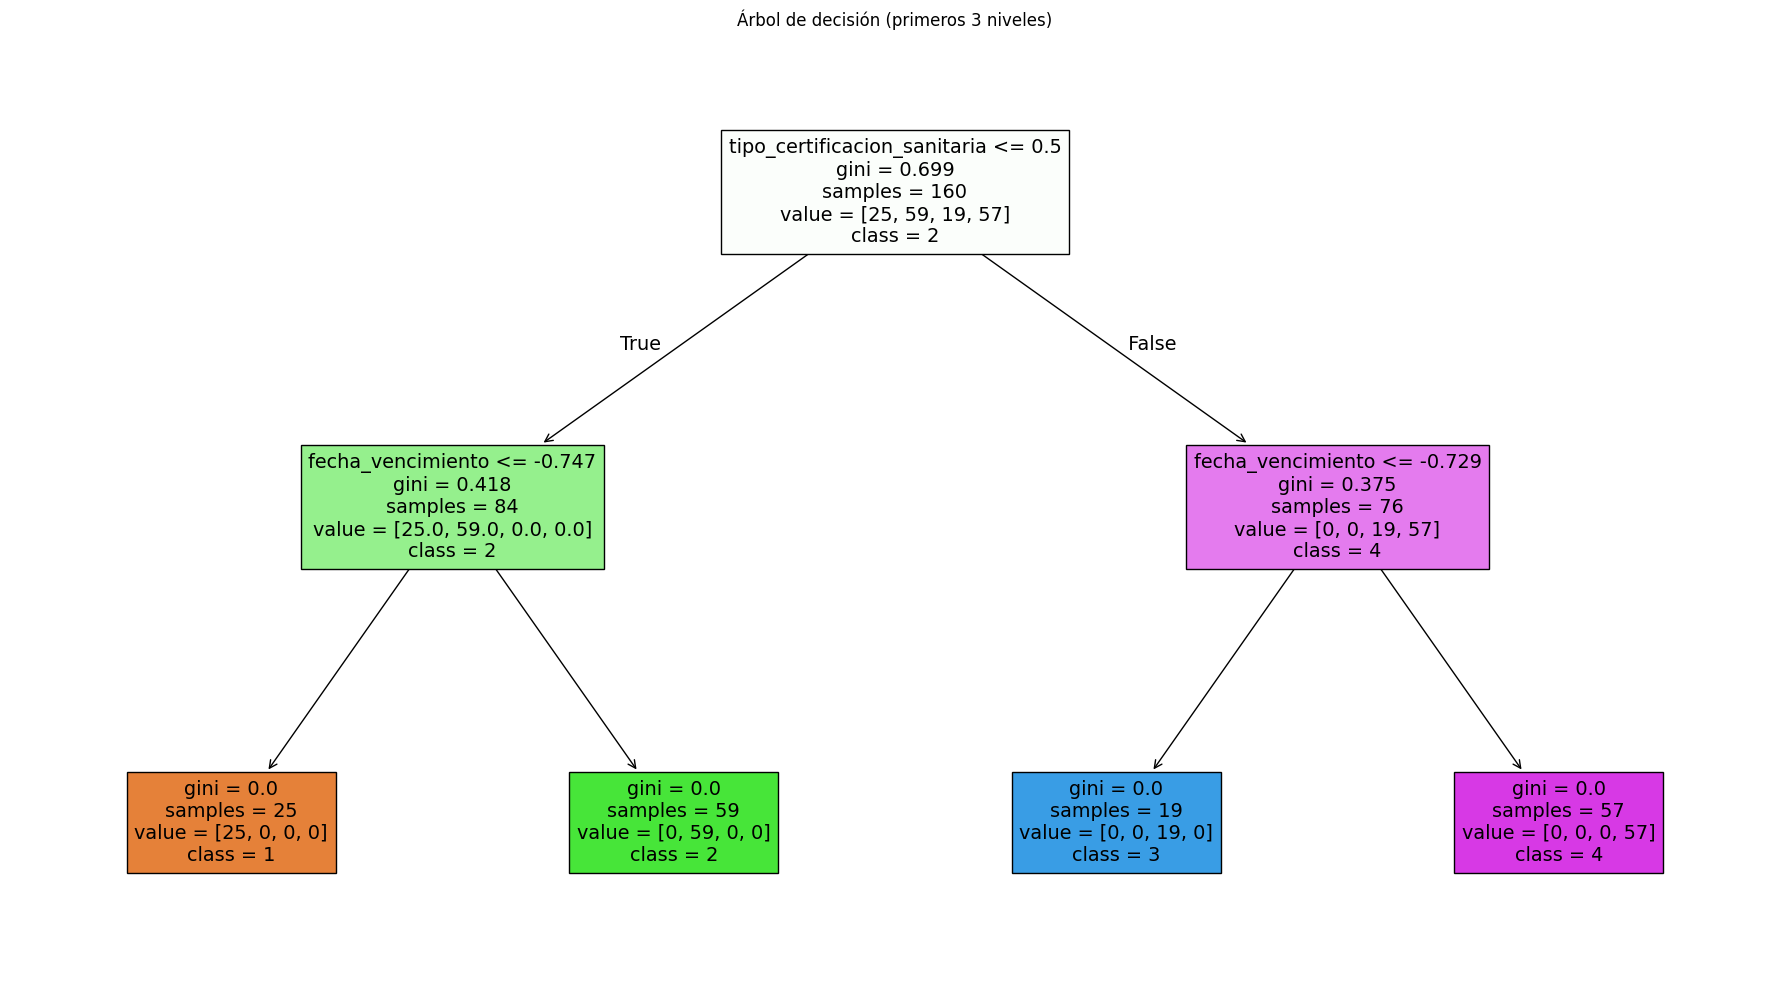

In [27]:
# --- Sección 11 (opcional): visualizar árbol ---
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

if isinstance(best_dt.named_steps["classifier"], DecisionTreeClassifier):
    # Obtenemos los nombres de columnas tras el preprocesamiento
    feature_names = []
    # ColumnTransformer: recuperamos nombres numéricos y categóricos expandidos
    # 1) num
    feature_names += num_cols
    # 2) cat (OneHot)
    ohe = best_dt.named_steps["preprocessor"].named_transformers_["cat"]
    ohe_feats = ohe.get_feature_names_out(cat_cols).tolist()
    feature_names += ohe_feats

    plt.figure(figsize=(18, 10))
    plot_tree(
        best_dt.named_steps["classifier"],
        feature_names=feature_names,
        class_names=[str(c) for c in clases],
        filled=True,
        max_depth=3  # corta el dibujo para que sea legible
    )
    plt.title("Árbol de decisión (primeros 3 niveles)")
    plt.tight_layout()
    plt.show()


In [28]:
# --- Sección 12: persistencia ---
import joblib
from pathlib import Path

Path("modelos").mkdir(exist_ok=True)
joblib.dump(best_dt, "modelos/mejor_decision_tree.joblib")
joblib.dump(best_mlp, "modelos/mejor_mlp.joblib")

# Predicciones finales del mejor modelo (elige uno para el informe)
# Aquí elegimos el que tenga mejor F1 macro en CV:
mejor_en_cv = ("Árbol de Decisión", best_dt) if grid_dt.best_score_ >= grid_mlp.best_score_ else ("MLP", best_mlp)
nombre, modelo = mejor_en_cv
print("Modelo elegido por CV:", nombre, "->", (grid_dt.best_score_ if nombre.startswith("Árbol") else grid_mlp.best_score_))

pred_test = pd.Series(modelo.predict(X_test), index=y_test.index, name="y_pred")
salida = pd.DataFrame({"y_true": y_test, "y_pred": pred_test})
salida.to_csv("predicciones_test.csv", index=False)
salida.head()


Modelo elegido por CV: Árbol de Decisión -> 1.0


,y_true,y_pred
94,2,2
161,3,3
97,1,1
163,2,2
12,4,4


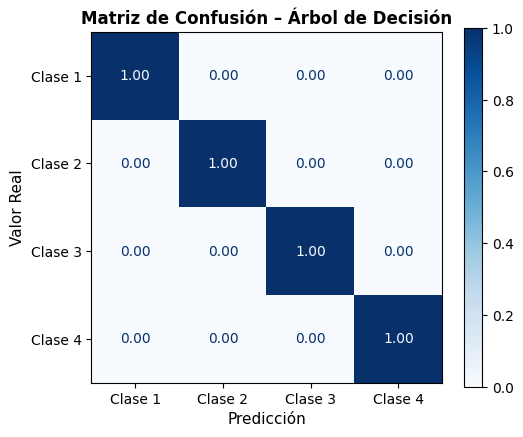

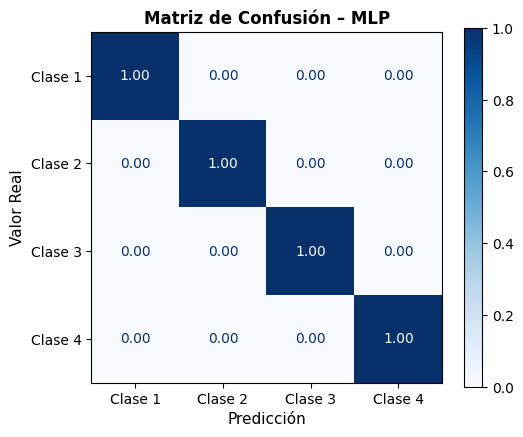

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# OJO con el nombre del dict: usa el que realmente tengas (modelos o models)
model_dict = modelos if 'modelos' in globals() else models

clases = np.array(sorted(pd.unique(y_train)))  # orden estable
for nombre, modelo in model_dict.items():
    fig, ax = plt.subplots(figsize=(5.5, 4.5))
    disp = ConfusionMatrixDisplay.from_estimator(
        modelo, X_test, y_test,
        display_labels=[f'Clase {c}' for c in clases],
        normalize='true', values_format='.2f', cmap='Blues', ax=ax
    )
    ax.set_title(f"Matriz de Confusión – {nombre}", fontweight='bold')
    ax.set_xlabel('Predicción', fontsize=11)
    ax.set_ylabel('Valor Real', fontsize=11)
    plt.tight_layout()
    plt.show()


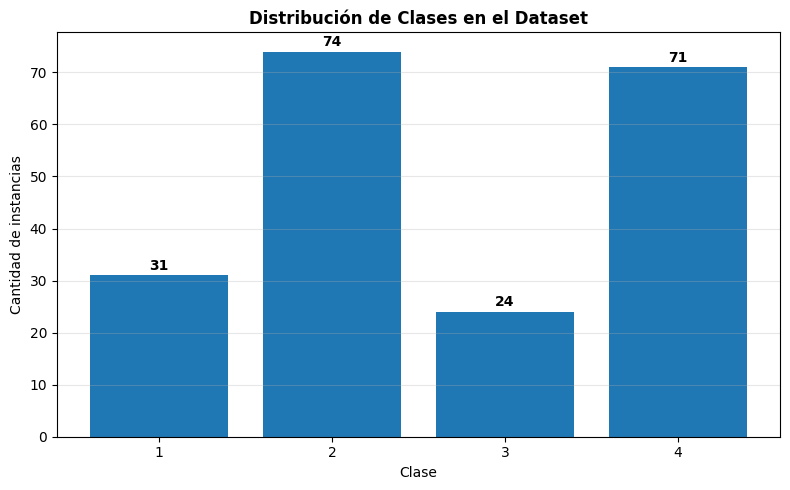

In [31]:
import matplotlib.pyplot as plt

serie = y.value_counts().sort_index()
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(serie.index.astype(str), serie.values)
ax.set_title('Distribución de Clases en el Dataset', fontweight='bold')
ax.set_xlabel('Clase')
ax.set_ylabel('Cantidad de instancias')
ax.grid(axis='y', alpha=0.3)

# Etiquetas encima de cada barra
for rect in bars:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height() + 0.5,
            str(int(rect.get_height())), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


Árbol de Decisión -> AUC OVR promedio (macro): 1.000


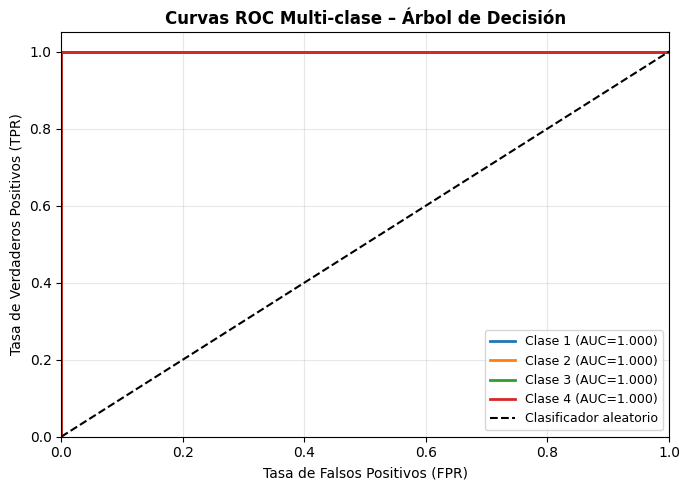

MLP -> AUC OVR promedio (macro): 1.000


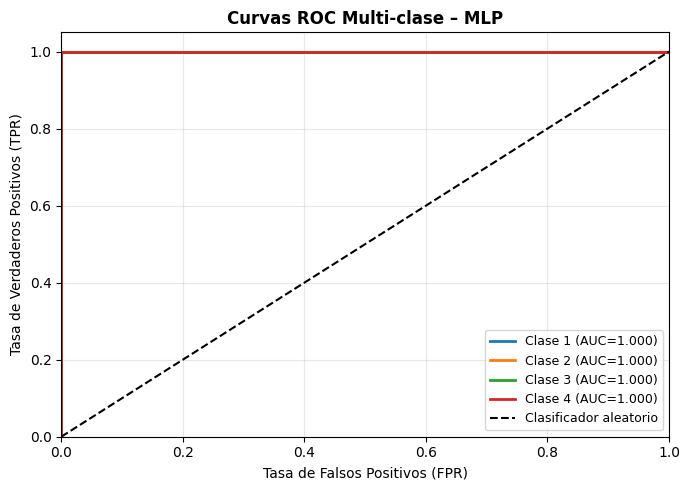

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Usa el dict correcto
model_dict = modelos if 'modelos' in globals() else models

# Ordena y fija las clases consistentemente
clases = np.array(sorted(pd.unique(y_train)))
y_test_bin = label_binarize(y_test, classes=clases)
n_clases = y_test_bin.shape[1]

def plot_roc_multiclase(nombre_modelo, modelo):
    if not hasattr(modelo, "predict_proba"):
        print(f"{nombre_modelo}: el modelo no expone predict_proba(), se omite ROC.")
        return

    y_score = modelo.predict_proba(X_test)  # (n_muestras, n_clases)
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(n_clases):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # AUC macro (promedio simple)
    auc_macro = float(np.mean(list(roc_auc.values())))
    print(f"{nombre_modelo} -> AUC OVR promedio (macro): {auc_macro:.3f}")

    # Plot de todas las clases
    fig, ax = plt.subplots(figsize=(7, 5))
    for i in range(n_clases):
        ax.plot(fpr[i], tpr[i], lw=2,
                label=f"Clase {clases[i]} (AUC={roc_auc[i]:.3f})")

    ax.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Clasificador aleatorio')
    ax.set_xlim([0.0, 1.0]); ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Tasa de Falsos Positivos (FPR)')
    ax.set_ylabel('Tasa de Verdaderos Positivos (TPR)')
    ax.set_title(f'Curvas ROC Multi-clase – {nombre_modelo}', fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

for nombre, modelo in model_dict.items():
    plot_roc_multiclase(nombre, modelo)


In [35]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, classification_report,
    precision_recall_fscore_support
)

model_dict = modelos if 'modelos' in globals() else models
clases = np.array(sorted(pd.unique(y_train)))

filas = []
f1_por_modelo = {}

for nombre, modelo in model_dict.items():
    y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    bacc = balanced_accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, labels=clases, zero_division=0
    )
    f1_macro = f1.mean()

    filas.append({
        "Modelo": nombre,
        "Accuracy": acc,
        "Balanced Acc.": bacc,
        "F1 macro": f1_macro
    })
    f1_por_modelo[nombre] = pd.Series(f1, index=[f"Clase {c}" for c in clases])

    print(f"\n== {nombre} ==")
    print(classification_report(y_test, y_pred, digits=3))

resumen = pd.DataFrame(filas).set_index("Modelo").sort_values("F1 macro", ascending=False)
display(resumen.round(3))



== Árbol de Decisión ==
              precision    recall  f1-score   support

           1      1.000     1.000     1.000         6
           2      1.000     1.000     1.000        15
           3      1.000     1.000     1.000         5
           4      1.000     1.000     1.000        14

    accuracy                          1.000        40
   macro avg      1.000     1.000     1.000        40
weighted avg      1.000     1.000     1.000        40


== MLP ==
              precision    recall  f1-score   support

           1      1.000     1.000     1.000         6
           2      1.000     1.000     1.000        15
           3      1.000     1.000     1.000         5
           4      1.000     1.000     1.000        14

    accuracy                          1.000        40
   macro avg      1.000     1.000     1.000        40
weighted avg      1.000     1.000     1.000        40



,Accuracy,Balanced Acc.,F1 macro
Modelo,,,
Árbol de Decisión,1.0,1.0,1.0
MLP,1.0,1.0,1.0


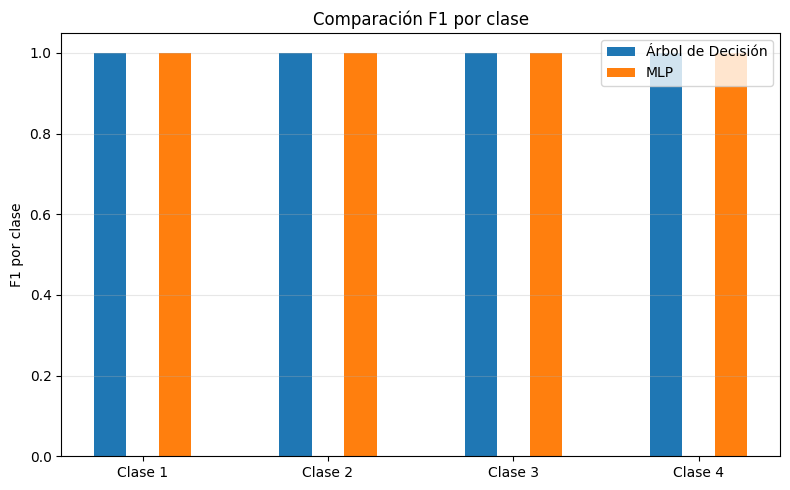

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5))
ancho = 0.35
x = np.arange(len(clases))
offsets = np.linspace(-ancho/2, ancho/2, len(f1_por_modelo))

for (nombre, serie), off in zip(f1_por_modelo.items(), offsets):
    ax.bar(x + off, serie.values, width=ancho/len(f1_por_modelo), label=nombre)

ax.set_xticks(x); ax.set_xticklabels([f"Clase {c}" for c in clases])
ax.set_ylim(0, 1.05)
ax.set_ylabel("F1 por clase")
ax.set_title("Comparación F1 por clase")
ax.grid(axis='y', alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


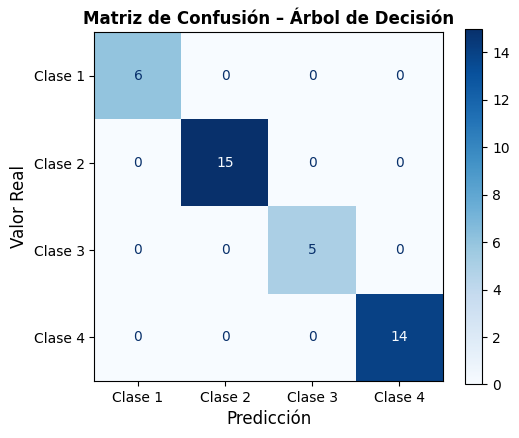

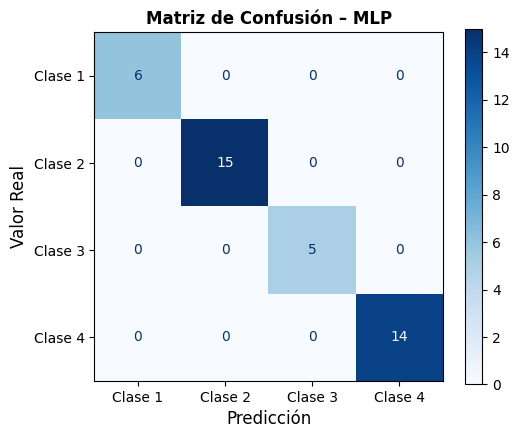

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Usa el dict correcto automáticamente
model_dict = modelos if 'modelos' in globals() else models

# Orden consistente de clases según el train
clases = np.array(sorted(pd.unique(y_train)))
# Etiquetas visibles (si prefieres sin "Clase", usa: labels_vis = clases.astype(str).tolist())
labels_vis = [f"Clase {c}" for c in clases]

# Cambia a True si prefieres matriz normalizada por filas
NORMALIZAR = False
normalize_arg = 'true' if NORMALIZAR else None
val_fmt = '.2f' if NORMALIZAR else 'd'

for nombre, modelo in model_dict.items():
    fig, ax = plt.subplots(figsize=(5.5, 4.5))
    ConfusionMatrixDisplay.from_estimator(
        modelo,
        X_test, y_test,
        display_labels=labels_vis,
        normalize=normalize_arg,
        values_format=val_fmt,
        cmap='Blues',
        ax=ax
    )
    ax.set_title(f"Matriz de Confusión – {nombre}", fontweight='bold')
    ax.set_xlabel('Predicción', fontsize=12)
    ax.set_ylabel('Valor Real', fontsize=12)
    plt.tight_layout()
    plt.show()


In [ ]:
#esta parte me da distinto